In [2]:
%%capture
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
#%pip install xgboost

In [61]:
# Data manipulation
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from pandas.plotting import scatter_matrix

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier 
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import balanced_accuracy_score

# Set parameters
from pylab import rcParams

rcParams['figure.figsize'] = 10, 6
rcParams['font.size'] = 12
rcParams['axes.facecolor'] = 'white'
plots_rgb_blue = 'rgb(31,119,180)'

%matplotlib inline

# Auckland Traffic Crash Model

### Model:
Create a model that can predict vehicle crashes in Auckland City.

### Datasets:
- Crash Analysis System - Waka Kotahi
- State Highway Traffic Volumes
- Population counts
- Auckland Transport Traffic Counts
- Weather Source

### Research Questions:
The purposes of creating a model are so that we can predict two research goals:

1. Identify crash hotspots in the Auckland roading network and factors that predict a high crash risk. It is Information that can be used to either plan resources such as Police traffic monitoring or emergency/hospital service rosters or target certain areas with preventative measures such as speed camera monitoring. There are well known high risk periods such as higher traffic volumes on public holidays periods, the aim is to broaden the model to predict a range of hotspots and identify the factors that contribute to them. 

2. Assess the various Government policies proposals related to reducing speed limits on streets around school areas in Auckland to predict a reduction in either the severity or frequency of crashes. 

### Analysis:

Meshblock, SA2 & SA3 descriptons can be found from statistics New Zealand

### Visualisation Output:
https://aucklandcrashmodel.streamlit.app/


### Executive Summary

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

### Research Links
https://www.sciencedirect.com/science/article/pii/S2590198223000611


# Data Wrangling 

In [5]:
# Code to merge dataframe performed by Gal Fybish, refer to notebook "prepare cas dataset for modelling"
# CAS Merged Data

file_path1 = 'cas_SA2_level.csv'
cas_SA2 = pd.read_csv(file_path1)

file_path2 = 'cas_SA3_level.csv'
cas_SA3 = pd.read_csv(file_path2)

In [6]:
cas_SA2.columns

Index(['halfYear', 'isHoliday', 'partOfDay', 'weatherA', 'weatherB',
       'SA2_Name', 'SA3_Name', 'trafficCount', 'population', 'crashesCount'],
      dtype='object')

In [7]:
cas_SA2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19309 entries, 0 to 19308
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   halfYear      19309 non-null  object 
 1   isHoliday     19309 non-null  int64  
 2   partOfDay     19309 non-null  object 
 3   weatherA      19309 non-null  object 
 4   weatherB      19309 non-null  object 
 5   SA2_Name      19309 non-null  object 
 6   SA3_Name      19309 non-null  object 
 7   trafficCount  19309 non-null  float64
 8   population    19309 non-null  float64
 9   crashesCount  19309 non-null  int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 1.5+ MB


In [8]:
cas_SA3.head()

,halfYear,isHoliday,partOfDay,weatherA,weatherB,SA3_Name,trafficCount,population,crashesCount
0,2018H1,0,Day,Fine,Frost,Avondale (Auckland),4.994207e+06,1533750.0,1
1,2018H1,0,Day,Fine,Frost,Belmont (Auckland),4.994207e+06,1533750.0,1
2,2018H1,0,Day,Fine,Frost,Birkenhead,4.994207e+06,1533750.0,1
3,2018H1,0,Day,Fine,Frost,Coatesville-Riverhead,4.994207e+06,1533750.0,1
4,2018H1,0,Day,Fine,Frost,East Tamaki,4.994207e+06,1533750.0,1


In [9]:
cas_SA2.head(10)

,halfYear,isHoliday,partOfDay,weatherA,weatherB,SA2_Name,SA3_Name,trafficCount,population,crashesCount
0,2018H1,0,Day,Fine,Frost,Armoy,East Tamaki,4.994207e+06,1533750.0,1
1,2018H1,0,Day,Fine,Frost,Avondale South (Auckland),Avondale (Auckland),4.994207e+06,1533750.0,1
2,2018H1,0,Day,Fine,Frost,Belmont (Auckland),Belmont (Auckland),4.994207e+06,1533750.0,1
3,2018H1,0,Day,Fine,Frost,Birkenhead North,Birkenhead,4.994207e+06,1533750.0,1
4,2018H1,0,Day,Fine,Frost,Coatesville,Coatesville-Riverhead,4.994207e+06,1533750.0,1
5,2018H1,0,Day,Fine,Frost,Glen Innes East-Wai O Taiki Bay,Glen Innes-Wai O Taiki Bay,4.994207e+06,1533750.0,1
6,2018H1,0,Day,Fine,Frost,Hatfields Beach,Hatfields Beach,4.994207e+06,1533750.0,1
7,2018H1,0,Day,Fine,Frost,Manurewa Central,Manurewa,4.994207e+06,1533750.0,1
8,2018H1,0,Day,Fine,Frost,Mount Wellington North East,Mount Wellington,4.994207e+06,1533750.0,1
9,2018H1,0,Day,Fine,Frost,Northcote Tuff Crater,Northcote (Auckland),4.994207e+06,1533750.0,1


# EDA/Data Visualisation


In [10]:
import plotly.express as px
# Plotting the boxplot using Plotly
fig = px.box(y=cas_SA2['crashesCount'], title="Crashes Count", color_discrete_sequence=['#21918c'])

# Update layout
fig.update_layout(
    width=600,  
    height=500,  
    xaxis_title="Count",
    yaxis_title="Crashes Count",
    showlegend=False
)

# Show the plot
fig.show()

In [11]:
cas_SA2.describe()

,isHoliday,trafficCount,population,crashesCount
count,19309.000000,1.930900e+04,1.930900e+04,19309.000000
mean,0.114662,4.946186e+06,1.591002e+06,2.749184
std,0.318621,4.507700e+05,3.609245e+04,3.455916
min,0.000000,3.964167e+06,1.533750e+06,1.000000
25%,0.000000,4.967806e+06,1.563250e+06,1.000000
50%,0.000000,5.041846e+06,1.588250e+06,1.000000
75%,0.000000,5.203575e+06,1.624250e+06,3.000000
max,1.000000,5.478786e+06,1.646500e+06,67.000000


One of the purposes of the crash model is to determine crash hotspots. A more useful model could be focusing on classifying areas where there are more crashes. Given that mean is 2.7 and std 3.4, most of the crash numbers are relatively low for each area. I'll create a label with 2 categories, up to 4 crashes and 5 or more crashes. 

In [12]:
holiday_counts = cas_SA2.groupby(['isHoliday']).count()
holiday_counts['crashesCount']

isHoliday
0    17095
1     2214
Name: crashesCount, dtype: int64

In [13]:
# Light Conditions were mapped 
partOfDay_counts = cas_SA2.groupby(['partOfDay']).count()
partOfDay_counts['crashesCount']

partOfDay
Day      10347
Night     8962
Name: crashesCount, dtype: int64

In [14]:
weatherA_counts = cas_SA2.groupby(['weatherA']).count()
weatherA_counts['crashesCount']

weatherA
Fine             12111
Hail or Sleet        4
Heavy rain        1510
Light rain        5255
Mist or Fog        428
Snow                 1
Name: crashesCount, dtype: int64

In [15]:
weatherB_counts = cas_SA2.groupby(['weatherB']).count()
weatherB_counts['crashesCount']

weatherB
Frost            331
Null           17859
Strong wind     1119
Name: crashesCount, dtype: int64

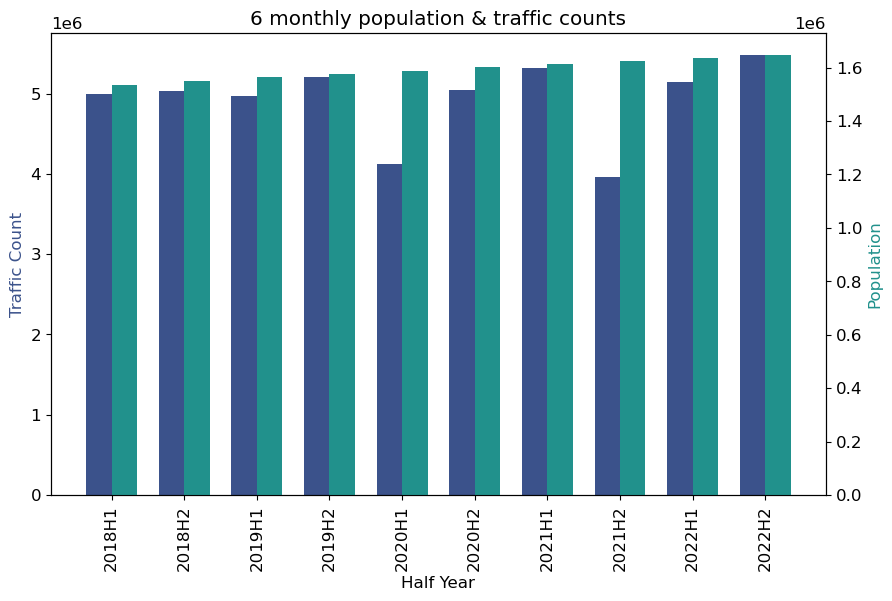

In [16]:
# Create 1 row per half year, dataset was prepared with repeating data.
pop_crash_data = cas_SA2.drop(['isHoliday', 'partOfDay', 'weatherA', 'weatherB',
       'SA2_Name', 'SA3_Name', 'crashesCount'], axis=1)
pop_crash_data = cas_SA2.drop_duplicates(subset=['halfYear'])

fig, ax1 = plt.subplots()

bar_width = 0.35
index = range(len(pop_crash_data['halfYear']))

bar1 = ax1.bar(index, pop_crash_data['trafficCount'], bar_width, label='Traffic Count', color='#3b528b')
ax2 = ax1.twinx()
bar2 = ax2.bar([i + bar_width for i in index], pop_crash_data['population'], bar_width, label='Population', color='#21918c')

ax1.set_xlabel('Half Year')
ax1.set_ylabel('Traffic Count', color='#3b528b')
ax2.set_ylabel('Population', color='#21918c')
ax1.set_xticks([i + bar_width / 2 for i in index])
ax1.set_xticklabels(pop_crash_data['halfYear'], rotation=90)
plt.title('6 monthly population & traffic counts')

plt.show()

In [17]:
pop_crash_data

,halfYear,isHoliday,partOfDay,weatherA,weatherB,SA2_Name,SA3_Name,trafficCount,population,crashesCount
0,2018H1,0,Day,Fine,Frost,Armoy,East Tamaki,4.994207e+06,1533750.0,1
2284,2018H2,0,Day,Fine,Frost,Avondale Central (Auckland),Avondale (Auckland),5.037423e+06,1549250.0,1
4266,2019H1,0,Day,Fine,Frost,Clover Park East,Clover Park,4.967806e+06,1563250.0,1
6150,2019H2,0,Day,Fine,Frost,Botany Junction,East Tamaki,5.203575e+06,1575750.0,1
8274,2020H1,0,Day,Fine,Frost,Bucklands Beach Central,Bucklands Beach,4.123442e+06,1588250.0,1
9963,2020H2,0,Day,Fine,Frost,Botany Junction,East Tamaki,5.041846e+06,1600750.0,1
11874,2021H1,0,Day,Fine,Frost,East Tamaki,East Tamaki,5.321994e+06,1612750.0,1
13911,2021H2,0,Day,Fine,Frost,Birdwood West,Waitakere West,3.964167e+06,1624250.0,1
15702,2022H1,0,Day,Fine,Frost,Conifer Grove East,Conifer Grove,5.146414e+06,1635500.0,1
17504,2022H2,0,Day,Fine,Frost,Cheltenham,Devonport,5.478786e+06,1646500.0,1


In [18]:
pop_crash_data['ratio'] = pop_crash_data['population']/pop_crash_data['trafficCount']
pop_crash_data

/var/folders/fv/pf3gh0017sg75klx31yfb1100000gn/T/ipykernel_82990/812263242.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,halfYear,isHoliday,partOfDay,weatherA,weatherB,SA2_Name,SA3_Name,trafficCount,population,crashesCount,ratio
0,2018H1,0,Day,Fine,Frost,Armoy,East Tamaki,4.994207e+06,1533750.0,1,0.307106
2284,2018H2,0,Day,Fine,Frost,Avondale Central (Auckland),Avondale (Auckland),5.037423e+06,1549250.0,1,0.307548
4266,2019H1,0,Day,Fine,Frost,Clover Park East,Clover Park,4.967806e+06,1563250.0,1,0.314676
6150,2019H2,0,Day,Fine,Frost,Botany Junction,East Tamaki,5.203575e+06,1575750.0,1,0.302821
8274,2020H1,0,Day,Fine,Frost,Bucklands Beach Central,Bucklands Beach,4.123442e+06,1588250.0,1,0.385176
9963,2020H2,0,Day,Fine,Frost,Botany Junction,East Tamaki,5.041846e+06,1600750.0,1,0.317493
11874,2021H1,0,Day,Fine,Frost,East Tamaki,East Tamaki,5.321994e+06,1612750.0,1,0.303035
13911,2021H2,0,Day,Fine,Frost,Birdwood West,Waitakere West,3.964167e+06,1624250.0,1,0.409733
15702,2022H1,0,Day,Fine,Frost,Conifer Grove East,Conifer Grove,5.146414e+06,1635500.0,1,0.317794
17504,2022H2,0,Day,Fine,Frost,Cheltenham,Devonport,5.478786e+06,1646500.0,1,0.300523


The ratio of traffic counts to population ranges from 0.3 to 0.4 from 2018 to 2022 in the Auckland region. These 3 variables might not contribute much to the model as a group. So I'll try adding/removing them and seeing the results.

In [19]:
# Prepare data for modelling
data = cas_SA2

# Adding the crash category, splitting the data by the mean, 3.4 (0 <= to mean, 1 is above the mean)
data['crashCategory'] = np.where(data['crashesCount'] <= 3.4, 0, 1)

# Adding the population to traffic volume ratio
data['ratio'] = data['population']/data['trafficCount']
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19309 entries, 0 to 19308
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   halfYear       19309 non-null  object 
 1   isHoliday      19309 non-null  int64  
 2   partOfDay      19309 non-null  object 
 3   weatherA       19309 non-null  object 
 4   weatherB       19309 non-null  object 
 5   SA2_Name       19309 non-null  object 
 6   SA3_Name       19309 non-null  object 
 7   trafficCount   19309 non-null  float64
 8   population     19309 non-null  float64
 9   crashesCount   19309 non-null  int64  
 10  crashCategory  19309 non-null  int64  
 11  ratio          19309 non-null  float64
dtypes: float64(3), int64(3), object(6)
memory usage: 1.8+ MB


In [20]:
# Note that taking crashes up to the mean 3.4. 
data['crashCategory'].value_counts()

crashCategory
0    15104
1     4205
Name: count, dtype: int64

# Model 

Test our various models and do further training and tuning on the best one.

In [53]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Define the preprocessing function
def pp(features, num_attribs, cat_attribs, fit=False, preprocessor_pipeline=None):
    # Ensure numeric columns are in the correct data type
    features[num_attribs] = features[num_attribs].apply(pd.to_numeric, errors='coerce')

    # Ensure categorical columns are in the correct data type
    features[cat_attribs] = features[cat_attribs].astype(str)
    
    if fit:
        # Define the numeric pipeline
        num_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill all nulls with the most frequent value
            ('scaler', StandardScaler())
        ])

        # Define the categorical pipeline
        cat_pipeline = Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill nulls with the most frequent value
            ('encoder', OneHotEncoder(handle_unknown='ignore'))  # Encode categorical variables
        ])

        # Combine the numeric and categorical pipelines into a preprocessor
        preprocessor_pipeline = ColumnTransformer([
            ("num", num_pipeline, num_attribs),
            ("cat", cat_pipeline, cat_attribs),
        ])

        # Fit and transform the features
        return preprocessor_pipeline, preprocessor_pipeline.fit_transform(features)
    else:
        # Just transform the features using the provided preprocessor_pipeline
        return preprocessor_pipeline, preprocessor_pipeline.transform(features)


In [25]:
# Function to calculate and plot ROC AUC
def roc_auc(y_test, y_pred_prob, name):
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    auc = roc_auc_score(y_test, y_pred_prob)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.grid(True)
    plt.legend(loc='best') 

# Classifiers with SA3

Both accuracy score and AUC (Area Under the ROC Curve) are commonly used metrics for evaluating the performance of classification models, but they capture different aspects of model performance.

Accuracy Score:

Accuracy is a measure of the proportion of correctly classified instances (both true positives and true negatives) out of the total number of instances.
It provides a simple and intuitive measure of overall model performance.
Accuracy is calculated as the ratio of the number of correct predictions to the total number of predictions.
While accuracy is easy to interpret and understand, it may not be the best metric for imbalanced datasets, where the class distribution is skewed.
AUC (Area Under the ROC Curve):

AUC measures the ability of a classifier to distinguish between positive and negative classes across all possible threshold settings.
It is computed by calculating the area under the Receiver Operating Characteristic (ROC) curve, which plots the true positive rate (sensitivity) against the false positive rate (1-specificity) at various threshold settings.
AUC provides a single scalar value that summarizes the overall performance of the classifier across all possible threshold settings.
AUC is particularly useful for imbalanced datasets, as it is less affected by class imbalance compared to accuracy.
In summary, accuracy score provides a measure of overall correctness of the classifier's predictions, while AUC provides a measure of the classifier's ability to discriminate between positive and negative classes. Both metrics are important and should be considered together when evaluating classification models, especially in the context of imbalanced datasets.

In [48]:
# TRAIN, VALIDATION AND TEST SETS

# - X_train: Training features
# - X_test: Testing features
# - y_train: Training target
# - y_test: Training Target

# Drop columns not to be used as features
X = data.drop(["halfYear","SA2_Name","crashesCount", "crashCategory","ratio"], axis=1)
y = data["crashCategory"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)
# Split the training data into train and validation

In [49]:
X.head(1)

,isHoliday,partOfDay,weatherA,weatherB,SA3_Name,trafficCount,population
0,0,Day,Fine,Frost,East Tamaki,4.994207e+06,1533750.0


In [55]:
num_attribs = ["isHoliday","trafficCount","population"]
cat_attribs = ["partOfDay","weatherA","weatherB","SA3_Name"]

In [56]:
# Fit and transform the train set
preprocessor_pipeline, X_train_processed = pp(X_train, num_attribs, cat_attribs, fit=True)

# Transform the test set using the fitted pipeline
_, X_test_processed = pp(X_test, num_attribs, cat_attribs, preprocessor_pipeline=preprocessor_pipeline)

print("Processed X_train shape:", X_train_processed.shape)
print("Processed X_test shape:", X_test_processed.shape)


Processed X_train shape: (15447, 205)
Processed X_test shape: (3862, 205)


Logistic Regression Accuracy: 0.88
k-NN Accuracy: 0.83
Random Forest Accuracy: 0.85
SGD Classifier Accuracy: 0.87
Decision Tree Accuracy: 0.83
SVM Accuracy: 0.87
XGBoost Accuracy: 0.86


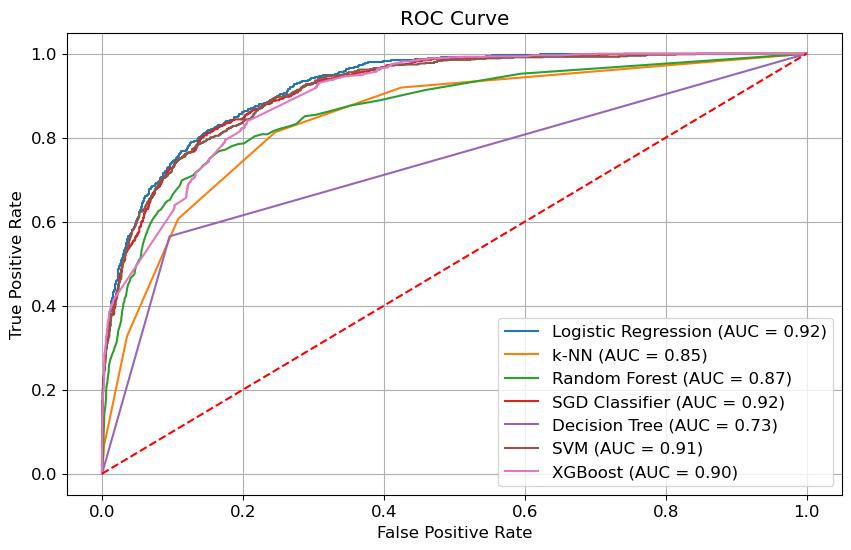

<Figure size 800x500 with 0 Axes>

In [62]:
# Allow 30 seconds to run
# List of classifiers to use
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SGD Classifier": SGDClassifier(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, clf in classifiers.items():
    clf.fit(X_train_processed, y_train)
    y_pred = clf.predict(X_test_processed)
    y_pred_prob = clf.predict_proba(X_test_processed)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test_processed)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc(y_test, y_pred_prob, name)
    print(f'{name} Accuracy: {accuracy:.2f}')


# Train and evaluate each classifier
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.figure(figsize=(8, 5))
plt.show()

# Classifiers with SA2

In [64]:
# TRAIN, VALIDATION AND TEST SETS

# - X_train: Training features
# - X_test: Testing features
# - y_train: Training target
# - y_test: Training Target

# Drop columns not to be used as features
X = data.drop(["halfYear","SA3_Name","crashesCount", "crashCategory","ratio"], axis=1)
y = data["crashCategory"]

# Split the training data into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

In [65]:
X.head(1)

,isHoliday,partOfDay,weatherA,weatherB,SA2_Name,trafficCount,population
0,0,Day,Fine,Frost,Armoy,4.994207e+06,1533750.0


In [66]:
num_attribs = ["isHoliday","trafficCount","population"]
cat_attribs = ["partOfDay","weatherA","weatherB","SA2_Name"]

In [67]:
# Fit and transform the train set
preprocessor_pipeline, X_train_processed = pp(X_train, num_attribs, cat_attribs, fit=True)

# Transform the test set using the fitted pipeline
_, X_test_processed = pp(X_test, num_attribs, cat_attribs, preprocessor_pipeline=preprocessor_pipeline)

print("Processed X_train shape:", X_train_processed.shape)
print("Processed X_test shape:", X_test_processed.shape)


Processed X_train shape: (15447, 605)
Processed X_test shape: (3862, 605)


Logistic Regression Accuracy: 0.88
k-NN Accuracy: 0.83
Random Forest Accuracy: 0.86
SGD Classifier Accuracy: 0.87
Decision Tree Accuracy: 0.84
SVM Accuracy: 0.87
XGBoost Accuracy: 0.86


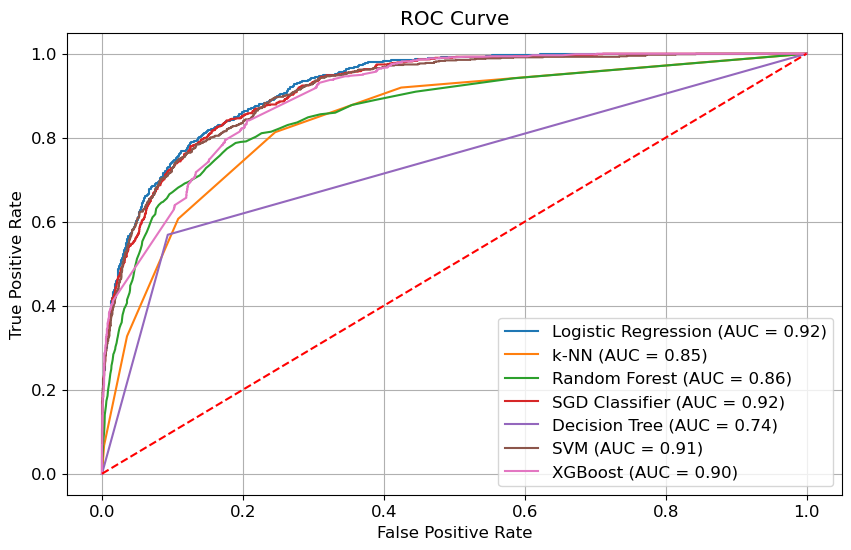

<Figure size 800x500 with 0 Axes>

In [68]:
# Allow 30 seconds to run
# List of classifiers to use
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "k-NN": KNeighborsClassifier(n_neighbors=5),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SGD Classifier": SGDClassifier(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "SVM": SVC(probability=True),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss')
}

for name, clf in classifiers.items():
    clf.fit(X_train_processed, y_train)
    y_pred = clf.predict(X_test_processed)
    y_pred_prob = clf.predict_proba(X_test_processed)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test_processed)
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc(y_test, y_pred_prob, name)
    print(f'{name} Accuracy: {accuracy:.2f}')


# Train and evaluate each classifier
plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess')
plt.figure(figsize=(8, 5))
plt.show()

# Regression SA3

This uses the crashes count for SA3 and the crashes count. Given that most of the crash numbers for each area are quite small, there isn't much for in each row to train on and have used hte larger geographic areas SA3 to have more crashes per row.

Results are poor given that most of crash numbers are low but there is an outlier area with 67 crashes.

In [74]:
# TRAIN, VALIDATION AND TEST SETS

# - X_train: Training features
# - X_test: Testing features
# - y_train: Training target
# - y_test: Training Target

# Drop columns not to be used as features
X = data.drop(["halfYear","SA2_Name","crashesCount", "crashCategory","ratio"], axis=1)
y = data["crashesCount"]

# Split the training data into train and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15)

In [70]:
X.head(1)

,isHoliday,partOfDay,weatherA,weatherB,SA3_Name,trafficCount,population
0,0,Day,Fine,Frost,East Tamaki,4.994207e+06,1533750.0


In [77]:
num_attribs = ["isHoliday","trafficCount","population"]
cat_attribs = ["partOfDay","weatherA","weatherB","SA3_Name"]

In [78]:
# Fit and transform the train set
preprocessor_pipeline, X_train_processed = pp(X_train, num_attribs, cat_attribs, fit=True)

# Transform the test set using the fitted pipeline
_, X_test_processed = pp(X_test, num_attribs, cat_attribs, preprocessor_pipeline=preprocessor_pipeline)

print("Processed X_train shape:", X_train_processed.shape)
print("Processed X_test shape:", X_test_processed.shape)

Processed X_train shape: (15447, 205)
Processed X_test shape: (3862, 205)


In [79]:
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR  # Changed from SVC to SVR for regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# List of Regressors to use
regressors = {
    "k-NN": KNeighborsRegressor(n_neighbors=5),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Support Vector Machine": SVR(),
    "SGD Regressor": SGDRegressor()
}

# Train and evaluate each regressor
for name, reg in regressors.items():
    reg.fit(X_train_processed, y_train)
    y_pred = reg.predict(X_test_processed)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f'{name} Performance:')
    print(f'Mean Absolute Error: {mae:.2f}')
    print(f'Mean Squared Error: {mse:.2f}')
    print(f'R^2 Score: {r2:.2f}')
    print('---------------------------')

k-NN Performance:
Mean Absolute Error: 1.53
Mean Squared Error: 7.45
R^2 Score: 0.27
---------------------------
Random Forest Performance:
Mean Absolute Error: 1.50
Mean Squared Error: 8.13
R^2 Score: 0.21
---------------------------
Support Vector Machine Performance:
Mean Absolute Error: 1.35
Mean Squared Error: 7.57
R^2 Score: 0.26
---------------------------
SGD Regressor Performance:
Mean Absolute Error: 1.72
Mean Squared Error: 7.46
R^2 Score: 0.27
---------------------------


# Conclusion 


Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. Duis aute irure dolor in reprehenderit in voluptate velit esse cillum dolore eu fugiat nulla pariatur. Excepteur sint occaecat cupidatat non proident, sunt in culpa qui officia deserunt mollit anim id est laborum

### Key findings:

1. Lorem ipsum dolor sit amet
2. Lorem ipsum dolor sit amet
3. Lorem ipsum dolor sit amet
4. ...

# Bibliography (optional) 